In [1]:
# library(splines)
library(fields)
library(splines2)
library(nimble)
library(vegan)
library(geosphere)


rm(list = ls())

Loading required package: spam

Spam version 2.11-0 (2024-10-03) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridisLite


Try help(fields) to get started.

nimble version 1.2.1 is loaded.
For more information on NIMBLE and a User Manual,
please visit https://R-nimble.org.

Note for advanced users who have written their own MCMC samplers:
  As of version 0.13.0, NIMBLE's protocol for handling posterior
  predictive nodes has changed in a way that could affect user-defined
  samplers in some situations. Please see Section 15.5.1 of the User Manual.


Attaching package: ‘nimble’


The following object is masked from ‘package:stats’:

    simulate


Loading required packa

In [10]:
#----------------------------------------------------------------
# load in and parse data
#----------------------------------------------------------------

dat_all = read.csv("../../data/sa_family_data.csv")
set.seed(1)
dat_all <- dat_all[sample(nrow(dat_all), 50), ]

# Parse data into location, environmental variables, and cover/presence data

location_mat = dat_all[,1:3] 
envr_use = dat_all[,c(4,5,8,9,10,11,12)] 
species_mat = dat_all[,-(1:12)] 

write.csv(location_mat, "CSV-comparisons/location_mat_R.csv", row.names = FALSE)
write.csv(envr_use, "CSV-comparisons/envr_use_R.csv", row.names = FALSE)
write.csv(species_mat, "CSV-comparisons/species_mat_R.csv", row.names = FALSE)

# save num ber of sites
ns = nrow(location_mat)

[1] 50


In [5]:
#----------------------------------------------------------------
# Calculate Bray-Curtis dissimilarity -- see proportion of 0's and 1's
#----------------------------------------------------------------

dist_use = as.matrix(vegdist(species_mat,"bray"))

Z = dist_use[lower.tri(dist_use)]

# index for those which are exactly one

Z_is_one = which(Z == 1)
Z_is_not_one = which(Z != 1)

# get counts

n1 = length(Z_is_one)
N = length(Z)

mean(Z == 0)
mean(Z == 1)

write.csv(Z, "CSV-comparisons/Z_R.csv", row.names = FALSE)

[1] 0

[1] 0.04081633

In [6]:
#----------------------------------------------------------------
# Define covariates that will be warped
#----------------------------------------------------------------

# Calculate geographical distance in km

dist_mat = distm(cbind(location_mat$longitude,location_mat$latitude))/1e3
vec_distance = dist_mat[lower.tri(dist_mat)]

write.csv(vec_distance, "CSV-comparisons/vec_distance_R.csv", row.names = FALSE)

# Define X to be environmental variables or a subset of them.

# How many knots do you want? What is the degree of the spline?
# Remember that in the specification, of the iSpline that the degree is
# one higher that what you say. Integration of m-spline adds one degree.

X = envr_use[,c("gmap","RFL_CONC","Elevation30m","HeatLoadIndex30m","tmean13c",
                "SoilConductivitymSm","SoilTotalNPercent")]
deg = 3
knots = 2
df_use = deg + knots

formula_use = as.formula(paste("~ 0 +",paste(
  paste("iSpline(`",colnames(X),"`,degree=",deg - 1 ,",df = ",df_use, 
        " ,intercept = TRUE)",sep = ""),collapse = "+")))

# combine distance and environmental I-spline base ranges (X_poly.shape[1]-2)

# X = 2*X

I_spline_bases = model.matrix(formula_use, data = X)

dist_splines = iSpline(vec_distance,degree = deg -1, df = df_use,intercept = TRUE)

write.csv(dist_splines, "CSV-comparisons/dist_splines_R.csv", row.names = FALSE)


# Creating a linearly spaced vector of x values to evaluate the shape of the spline
x <- seq(0, 1, length.out = 100)
df <- data.frame(x = x)
I_splines_x = model.matrix(as.formula(paste("~ 0 +", paste("iSpline(`", colnames(df), "`, degree =", deg-1, ", df =", df_use, ", intercept = TRUE)", sep = ""), collapse = "+")), data = df)

write.csv(df, "CSV-comparisons/x_R.csv", row.names = FALSE)
write.csv(I_splines_x, "CSV-comparisons/I_splines_x_R.csv", row.names = FALSE)
write.csv(I_spline_bases, "CSV-comparisons/I_spline_bases_R.csv", row.names = FALSE)
write.csv(X, "CSV-comparisons/X_R.csv", row.names = FALSE)

X_GDM = cbind(sapply(1:ncol(I_spline_bases),function(i){
  
  dist_temp = rdist(I_spline_bases[,i])
  vec_dist = dist_temp[lower.tri(dist_temp)]
  vec_dist
  
}),
iSpline(vec_distance,degree = deg -1,
        df = df_use,intercept = TRUE)
)

p = ncol(X_GDM)


colnames(X_GDM) = c(
  paste(rep(colnames(X),each = df_use ),"I",rep(1:df_use,times = ncol(X)),sep = ""),
  paste("dist","I",1:df_use,sep = "")
)

write.csv(X_GDM, "CSV-comparisons/X_GDM_R.csv", row.names = FALSE)

### Associate each dissimilarity with two sites (row and col index)

tmp = matrix(rep(1:nrow(dist_use),each = nrow(dist_use)),nrow = nrow(dist_use))
col_ind = tmp[lower.tri(tmp)]
tmp = matrix(rep(1:nrow(dist_use),times = nrow(dist_use)),nrow = nrow(dist_use))
row_ind = tmp[lower.tri(tmp)]

[1] 202.6667 230.3333
[1]  90 352


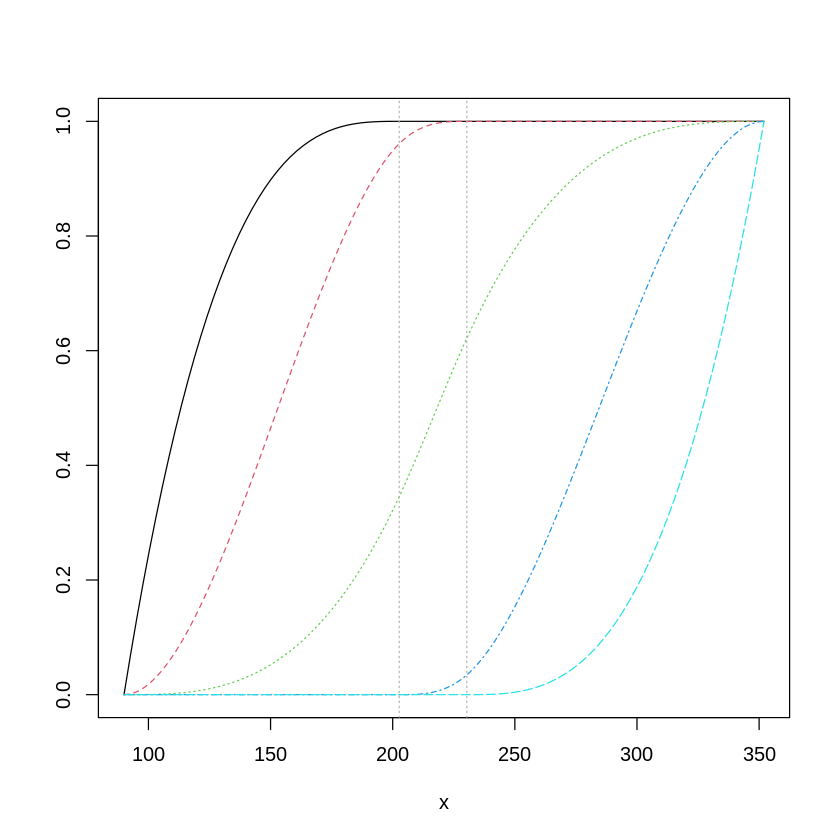

In [7]:
knots <- list(min(X[,1]) + (max(X[,1]) - min(X[,1])) / 3, min(X[,1]) + (max(X[,1]) - min(X[,1]))* 2 / 3)

I_spline_test <- iSpline(X[, 1], degree = deg - 1, df = df_use, intercept = TRUE)

plot(I_spline_test, mark_knots = 'internal')

internal_knots <- knots(I_spline_test)
boundary_knots <- knots(I_spline_test, type = 'boundary')

print(internal_knots)
print(boundary_knots)

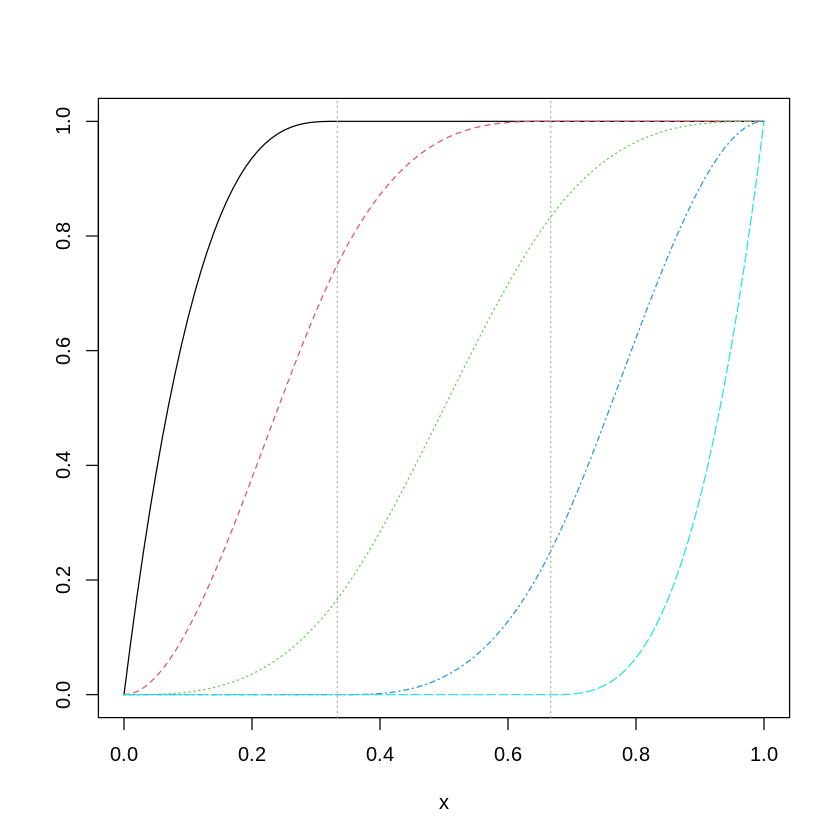

In [8]:
I_splines_x_test <- iSpline(df$x, degree = deg - 1, df = df_use, intercept = TRUE)

plot(I_splines_x_test, mark_knots = 'internal')

In [11]:
# Get dimensions of X_GDM
dim_X_GDM <- dim(X_GDM)
print(dim_X_GDM)

# Get length of Z
length_Z <- length(Z)
print(length_Z)

[1] 1225   40
[1] 1225


In [18]:
#------------------------------------------------------------------------
# Get Initial values for modeling fitting
#------------------------------------------------------------------------

lm_mod = lm(log(Z) ~ X_GDM)

lm_out = optim(c(.3, ifelse(coef(lm_mod)[-1] > 0, log(coef(lm_mod)[-1]), -10), rnorm(ns)), function(par) {
  sum((log(Z) - par[1] - X_GDM %*% exp(par[2:(p + 1)]))^2)
}, method = "BFGS")

write.csv(lm_out$par, "CSV-comparisons/optimised_params_R.csv", row.names = FALSE)
write.csv(lm_out$value, "CSV-comparisons/optimised_value_R.csv", row.names = FALSE)
write.csv(lm_out$counts, "CSV-comparisons/optimised_counts_R.csv", row.names = FALSE)

Warning message in log(coef(lm_mod)[-1]):
“NaNs produced”


In [20]:
#------------------------------------------------------------------------
# Fix spatial range parameter (rho = 1 / phi)
#------------------------------------------------------------------------
rho_fix = max(dist_mat)/10
R_spat_mat = exp(-dist_mat/rho_fix)
chol_R = t(chol(R_spat_mat))
R_inv = solve(R_spat_mat)

write.csv(R_spat_mat, "CSV-comparisons/R_spat_mat_R.csv", row.names = FALSE)
write.csv(R_inv, "CSV-comparisons/R_inv_R.csv", row.names = FALSE)

#------------------------------------------------------------------------
# Define design matrix for polynomial log-variance
#------------------------------------------------------------------------

X_sigma = cbind(1,poly(vec_distance,degree = 3))
p_sigma = ncol(X_sigma)

In [2]:
#------------------------------------------------------------------------
# Source nimble models -- Models 1-9 match those in paper
#------------------------------------------------------------------------

source("../nimble_models.R")

# create constants for nimble model

constants <- list(n = N, p = p, x = X_GDM,n_loc = ns,
                  p_sigma = p_sigma,X_sigma = X_sigma,R_inv = R_inv, 
                  zeros = rep(0, ns),row_ind = row_ind, col_ind = col_ind)

# create data for nimble model

data <- list(log_V = ifelse(Z == 1,NA, log(Z)),
             censored = 1*(Z == 1),
             c = rep(0,constants$n))

# create initial values for nimble model -- this will change depending on model

inits <- list(beta_0 = lm_out$par[1],
              log_beta = lm_out$par[2:(p+1)],
              sig2_psi = 1,
              beta_sigma = c(-5,-20,12,2),
              psi = lm_out$par[-(1:(p+1))])

#### "nimble_code1" is model 1 in paper. Change to what you want in nimble_models.R.

model <- nimbleModel(nimble_code1, constants = constants, data = data, inits = inits)

mcmcConf <- configureMCMC(model)

# Block sampler for beta_0, log(\beta_{jk}), and \beta_{\sigma}
# MCMC may work better including psi in this blocking
# Some models (1,4,7) won't have beta_sigma
mcmcConf$removeSamplers(c("beta_0",'log_beta','sigma2'))
# mcmcConf$addSampler(target = c("beta_0",'log_beta',"sigma2"), type = 'RW_block')
mcmcConf$addSampler(target = c("beta_0",'log_beta','sigma2'), 
                    type = 'AF_slice')
# 
# May need to change depending on model
# For example, models 1, 4, and 7 will have "sigma2" instead of "beta_sigma"
# For example, models 1, 2, and 3 will not have "psi"
### Here, beta represents beta* discussed in the supplement, the product of alpha_k and \beta_{k,j}

mcmcConf$addMonitors(c('beta_0','beta','sigma2'))

mcmcConf$enableWAIC = TRUE
codeMCMC <- buildMCMC(mcmcConf)
Cmodel = compileNimble(codeMCMC,model)

##### Run a super long MCMC
##### thin so that we get 10,000 posterior samples -- saves memory

n_tot = 10e3
n_burn = 5e3
n_post = n_tot - n_burn


# You may get some warnings because we didn't initialize log_V where Z = 1.
st = proc.time()
post_samples <- runMCMC(Cmodel$codeMCMC,niter = n_tot,nburnin = n_burn,
                        thin = 1,WAIC = TRUE)
elapsed = proc.time() - st

saveRDS(data.frame(model = 1,
                   time_mins = elapsed[1]/60,
                   WAIC = post_samples$WAIC$WAIC,
                   p_WAIC =  post_samples$WAIC$pWAIC,
                   lppd = post_samples$WAIC$lppd
                   ),"mod1_sa.rds")

rm(list=ls())

# ##### A few trace plot
# plot(post_samples$samples[,"beta_0"],type= "l")
# plot(post_samples$samples[,"log_beta[9]"],type= "l")
# plot(post_samples$samples[,"beta[9]"],type= "l")
# 
# plot(post_samples$samples[,"beta_sigma[2]"],type= "l")
# plot(post_samples$samples[,"psi[2]"],type= "l")
# plot(post_samples$samples[,"sig2_psi"],type= "l")


ERROR: Error in nimbleCode({: could not find function "nimbleCode"
